In [1]:
import numpy as np
import matplotlib.pyplot as plt

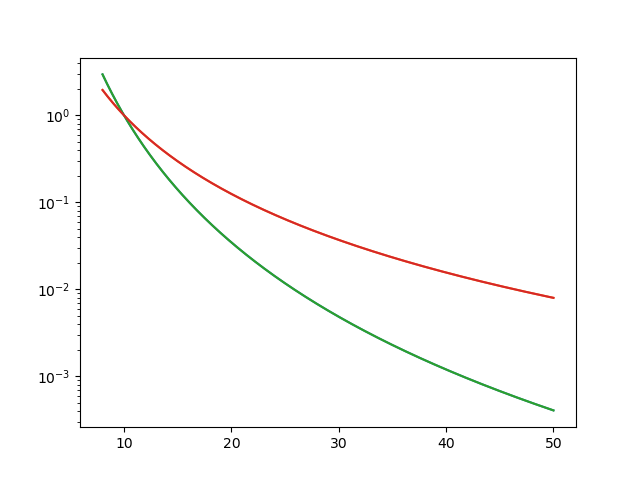

Fraction of stars more massive than 20 Msun over those more massive than 8 Msun for alpha = -4.85: 0.0283971618192818
Fraction of stars more massive than 20 Msun over those more massive than 8 Msun for alpha = -3.0: 0.13753566492989497


In [7]:
%matplotlib widget
# We will define the PDMF for stars larger than 8 Msun as a power-law

m = np.linspace(8, 50, 1000)
alpha_1 = -4.85
alpha_2 = -3.0
pmdf_1 = m ** alpha_1
pmdf_2 = m ** alpha_2

# Plot the PDMF
plt.figure(1)
plt.plot(m, pmdf_1 / 10 ** alpha_1)
plt.plot(m, pmdf_2 / 10 ** alpha_2)
plt.show()
plt.yscale('log')

# For each alpha, calculate the fraction of stars more massive than X Msun over those more massive than 8 Msun
cut_mass = 20
frac_1 = np.trapz(pmdf_1[m >= cut_mass], m[m >= cut_mass]) / np.trapz(pmdf_1, m)
frac_2 = np.trapz(pmdf_2[m >= cut_mass], m[m >= cut_mass]) / np.trapz(pmdf_2, m)

print(f"Fraction of stars more massive than {cut_mass} Msun over those more massive than 8 Msun for alpha = {alpha_1}: {frac_1}")
print(f"Fraction of stars more massive than {cut_mass} Msun over those more massive than 8 Msun for alpha = {alpha_2}: {frac_2}")


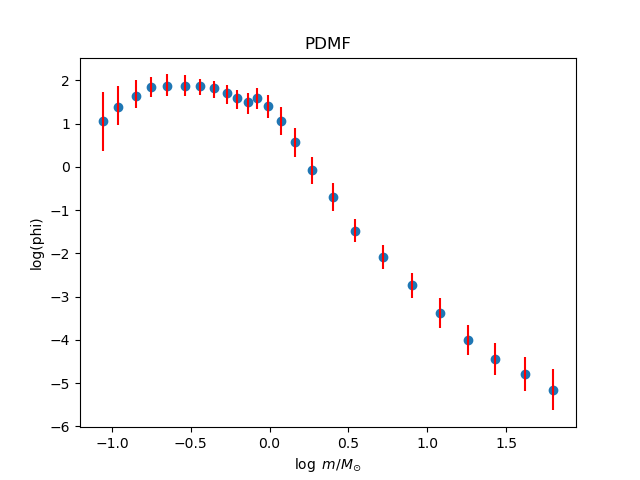

Total number of stars (in main-sequence) per unit area: 5.776e+01
Total number of stars (in main-sequence) in the Milky Way: 4.082e+10
Total number of stars in the Milky Way: 4.536e+10


In [3]:
# Load the PDMF data
# Load the PDMF data with named columns
pdmf_data = np.genfromtxt('mass_function.dat', 
                         names=['M_i', 'log_m', 'log_phi_plus_10', 'dm_d_log_m', 'two_H', 
                                'g_m', 'log_phi_log_m', 'e_log_phi_low', 'e_log_phi_high'],
                         comments='#')
# Reverse the order of the data (as it starts at the highest mass)
pdmf_data = pdmf_data[::-1]

# Plot the PDMF
log_m = pdmf_data["log_m"]
log_phi = pdmf_data["log_phi_log_m"] # log phi has units log^-1 m pc^-2
lower_error = pdmf_data["e_log_phi_low"]
upper_error = pdmf_data["e_log_phi_high"]

# Plot the PDMF with error bars
plt.figure(2)
plt.scatter(log_m, log_phi)
plt.errorbar(log_m, log_phi, yerr=[lower_error, upper_error], fmt='none', ecolor='red')
plt.xlabel(r'$\log\ m/M_{\odot}$')
plt.ylabel('log(phi)')
plt.title('PDMF')
plt.show()

# We're gonna integrate the PDMF to get the total number of stars in the Milky Way
# We'll assume that the Milky Way is ~30 kpc in diameter and uniformly distributed
milky_way_radius = 15 # kpc
milky_way_area = np.pi * milky_way_radius ** 2 * 1e6  # pc^2
phi = 10 ** log_phi
m = 10 ** log_m

total_stars_per_unit_area_main_sequence = np.trapz(phi, log_m)
total_stars_main_sequence = total_stars_per_unit_area_main_sequence * milky_way_area

print(f"Total number of stars (in main-sequence) per unit area: {total_stars_per_unit_area_main_sequence:.3e}")
print(f"Total number of stars (in main-sequence) in the Milky Way: {total_stars_main_sequence:.3e}")

total_stars = total_stars_main_sequence / 0.9 # ~90% of stars are on the main sequence
print(f"Total number of stars in the Milky Way: {total_stars:.3e}")


In [6]:
# Fit a power-law to the PDMF for m > n Msun
n = 7.5
mask = log_m > np.log10(n)

# Select the data points for the fit
x_fit = log_m[mask]
y_fit = log_phi[mask]

# Perform a linear regression (in log-log space) to fit a power-law:
# Model: log_phi = slope * log_m + intercept, which corresponds to phi(m) = 10**intercept * m^(slope)
coeffs = np.polyfit(x_fit, y_fit, 1)
fit_slope, fit_intercept = coeffs
print(f"Fitted power-law parameters (for m > {n} * Msun): slope = {fit_slope:.3f}, intercept = {fit_intercept:.3f}")

# Generate the fitted model over the range of log_m values
y_model = fit_slope * log_m + fit_intercept

# Plot the original PDMF data (with error bars) and overlay the fitted power-law curve
plt.figure()
plt.errorbar(log_m[mask], log_phi[mask], yerr=[lower_error[mask], upper_error[mask]], fmt='o', color='red', alpha=0.7, label='PDMF Data')
plt.plot(log_m[mask], y_model[mask], 'k--', label=f'Fit: slope = {fit_slope:.2f}')
plt.xlabel(r'$\log\ m/M_{\odot}$')
plt.ylabel('log(phi)')
plt.title(f'Power-law Fit to the PDMF (m > {n}' + r'$M_{\odot}$)')
plt.legend()
plt.show()

# We can estimate the number of SN candidates in the Milky Way by integrating the PDMF over the range of masses that produce SN explosions
# We'll assume that the mass range for SN production is > 8 Msun
m_threshold = 8
threshold_mask = log_m > np.log10(m_threshold)

# print(phi[threshold_mask])
# print(10**y_model[threshold_mask])

total_sn_candidates_per_unit_area = np.trapz(phi[threshold_mask], log_m[threshold_mask])
total_sn_candidates_per_unit_area_power_law = np.trapz(10**y_model[threshold_mask], log_m[threshold_mask])
total_sn_candidates = total_sn_candidates_per_unit_area * milky_way_area
total_sn_candidates_power_law = total_sn_candidates_per_unit_area_power_law * milky_way_area

print(f"Total number of SN candidates per unit area: {total_sn_candidates_per_unit_area:.3e}")
print(f"Total number of SN candidates in the Milky Way: {total_sn_candidates:.3e}")
print(f"Total number of SN candidates in the Milky Way from fit: {total_sn_candidates_power_law:.3e}")

# How many SN candidates will explode per year?
# Assuming a power law (see notebook for derivation)
k = 10 ** fit_intercept * milky_way_area / np.log(10)
slope = -3.0 #fit_slope
alpha = -slope + 1
upper_mass = np.max(m)
n_deaths_power_law = 1e-10 * k * (upper_mass ** (2.5 - alpha + 1) - m_threshold ** (2.5 - alpha + 1)) / (2.5 - alpha + 1)

# Integrating the PDMF directly
# We showed that phi(m) * dm = phi(log_m) * d(log_m) (the m and ln 10 cancel out)
n_deaths = 1e-10 * np.trapz(phi[threshold_mask] * m[threshold_mask]**2.5, log_m[threshold_mask]) * milky_way_area
# phi_m = phi / (m * np.log(10))
# n_deaths_2 = 1e-10 * np.trapz(phi_m[threshold_mask] * m[threshold_mask]**2.5, m[threshold_mask]) * milky_way_area
# print(n_deaths, n_deaths_2)
# n_deaths_3 = 1e-10 * np.trapz(10**y_model[threshold_mask] * m[threshold_mask]**2.5, log_m[threshold_mask]) * milky_way_area
# print(n_deaths, n_deaths_3, n_deaths_power_law)

print(f"Number of SN candidates that will explode per year (integrating PDMF): {n_deaths:.3e}")
print(f"Number of SN candidates that will explode per year (power law): {n_deaths_power_law:.3e}")

# This implies how many SN per century?
correction_factor = np.array([1e11 / total_stars, 4e11 / total_stars])
n_deaths_per_century = n_deaths * 100
n_deaths_per_century_power_law = n_deaths_power_law * 100
n_deaths_per_century_corrected = n_deaths * 100 * correction_factor
n_deaths_per_century_power_law_corrected = n_deaths_power_law * 100 * correction_factor

print(f"Number of SN candidates that will explode per century: {n_deaths_per_century}")
print(f"Number of SN candidates that will explode per century (power law): {n_deaths_per_century_power_law}")
print(f"Number of SN candidates that will explode per century (corrected):" +
        f" {n_deaths_per_century_corrected.min()} to {n_deaths_per_century_corrected.max()}")
print(f"Number of SN candidates that will explode per century (power law corrected):" +
        f" {n_deaths_per_century_power_law_corrected.min()} to {n_deaths_per_century_power_law_corrected.max()}")






Fitted power-law parameters (for m > 7.5 * Msun): slope = -2.654, intercept = -0.503


Total number of SN candidates per unit area: 6.574e-05
Total number of SN candidates in the Milky Way: 4.647e+04
Total number of SN candidates in the Milky Way from fit: 5.355e+04
Number of SN candidates that will explode per year (integrating PDMF): 8.663e-03
Number of SN candidates that will explode per year (power law): 4.389e-03
Number of SN candidates that will explode per century: 0.8663113269544853
Number of SN candidates that will explode per century (power law): 0.4389100466826595
Number of SN candidates that will explode per century (corrected): 1.9098171636688563 to 7.639268654675425
Number of SN candidates that will explode per century (power law corrected): 0.9675943444120313 to 3.870377377648125
